In [2]:
# Load some libraries we will use below.
import matplotlib, sklearn, numpy as np, matplotlib.pyplot as plt, math
%matplotlib inline
plt.rcParams["figure.figsize"] = (8,5)

In [3]:
import pandas as pd
from time import time


## Load the raw data

In [4]:
import gzip, json, re
raw = json.load(gzip.open("simpsonswiki.json.gz", "rt", encoding="utf-8"))
print(len(raw))

10126


In [5]:
# Inspect the text of the second object
print(raw[2]['text'])

Bart Jumps is the third Simpsons short which aired on The Tracey Ullman Show on May 10, 1987.

Plot

This Simpsons short opens with Bart attempting to jump into Homer’s arms "just like the good old days". The first time Bart jumps, he lands on his head, bouncing and falling on the floor. Once again, Bart prepares to jump. Bart asks Homer why this task is necessary, while Homer asserts that it is always because he has been so jumpy. Bart jumps again, but because Homer was laughing at the previous comment, he fails to catch Bart. Bart gets a bandage and a bruise from a previous jump. Again Bart jumps, but Homer is distracted while he attempts to work out the past tense of the word "leap". He collects the dictionary and discovers they are both acceptable, and once again Bart lies on the floor. For the final time, Bart is ready to jump. As Homer goes to answer the door, Bart closes his eyes and leaps. As he lies on his back, Homer returns with two pairs of boxing gloves announcing they hav

## 2-1 Preprocess the Text

Process the text into a list of word tokens.

You are free to experiment with more advanced techniques for your project, but as a baseline you should remove capitalization, non-word characters and perform some basic word filtering (e.g., remove stopwords, remove words of length less than 3, etc.).

In [6]:
import nltk
from nltk.corpus import stopwords

from nltk import word_tokenize


In [7]:
#let's use the stopwords from nltk
stop_words = set(stopwords.words('english'))

In [8]:
tokens = []

#tokenize our documents by iterating over each text with basic preprocessing
for index in range(len(raw)):
    tokens.append([w for w in word_tokenize(raw[index]['text'].lower()) 
                                        if len(w)>3 and not w in stop_words])

In [9]:
all_tokens = []

for i in range(len(tokens)):
    for word in tokens[i]:
        all_tokens.append(word)
        
all_tokens = set(all_tokens)
#this will be helpful later

In [10]:
#this is the tokenized text from above
print(tokens[2], end='')

['bart', 'jumps', 'third', 'simpsons', 'short', 'aired', 'tracey', 'ullman', 'show', '1987.', 'plot', 'simpsons', 'short', 'opens', 'bart', 'attempting', 'jump', 'homer', 'arms', 'like', 'good', 'days', 'first', 'time', 'bart', 'jumps', 'lands', 'head', 'bouncing', 'falling', 'floor', 'bart', 'prepares', 'jump', 'bart', 'asks', 'homer', 'task', 'necessary', 'homer', 'asserts', 'always', 'jumpy', 'bart', 'jumps', 'homer', 'laughing', 'previous', 'comment', 'fails', 'catch', 'bart', 'bart', 'gets', 'bandage', 'bruise', 'previous', 'jump', 'bart', 'jumps', 'homer', 'distracted', 'attempts', 'work', 'past', 'tense', 'word', 'leap', 'collects', 'dictionary', 'discovers', 'acceptable', 'bart', 'lies', 'floor', 'final', 'time', 'bart', 'ready', 'jump', 'homer', 'goes', 'answer', 'door', 'bart', 'closes', 'eyes', 'leaps', 'lies', 'back', 'homer', 'returns', 'pairs', 'boxing', 'gloves', 'announcing', 'arrived']

## 2-2 Built a simple inverted index

It is enough to use a dictionary for this, mapping words to sorted lists of documents. Do not consider duplicate words, no position information. You do not need to optimize the code, not even numpy is necessary, as this data set is small.

Use your *index* to answer the following questions:

* how many different words do you have after your preprocessing above?


In [11]:
from collections import defaultdict

I will be using python's defaultdict.

In [12]:
def create_index_set (documents):
    index_set = defaultdict(set)
    for i, tokens in enumerate(documents):
        for token in tokens:
            index_set[token].add(i)
    return index_set

In [13]:
index_set = create_index_set(tokens)


In [14]:
ind_language = index_set['language']

print('The word "language" is used in the following documents:',ind_language)

The word "language" is used in the following documents: {129, 8451, 644, 902, 1287, 2953, 1546, 2317, 1040, 1938, 7447, 9753, 29, 542, 159, 3614, 3615, 3617, 675, 3620, 6179, 9632, 10016, 297, 298, 3243, 301, 429, 56, 2234, 59, 3259, 834, 1479, 6087, 6217, 334, 7761, 3157, 216, 9049, 2397, 4061, 8163, 2155, 750, 495, 112, 6640, 7540, 1143, 252, 382}


In [15]:
def count_occ(tokens):
    count = defaultdict(int)
    for i, doc in enumerate(tokens):
        for token in doc:
            count[token] = len(index_set[token])
    return count

In [16]:
token_count = count_occ(tokens)

In [17]:
token_count['language']

53

In [18]:
print("A total of", len(index_set.keys()), "Tokens remain after Preprocessing")

A total of 44823 Tokens remain after Preprocessing


* how many words occur in at least 10 documents?


In [19]:
tokens_ten = []

for i in range(len(tokens)):
    for xyz in tokens[i]:
        if token_count.get(xyz)>9:
            tokens_ten.append(xyz)
            
distinct_tokens_ten = set(tokens_ten)

In [20]:
print("Only", len(distinct_tokens_ten), "tokenized words occur at least ten times.")

Only 8447 tokenized words occur at least ten times.


* what are the 20 most frequent words (by document frequency)?

In [21]:
from collections import Counter

print(Counter(token_count).most_common(20), end='')

[('homer', 4307), ('springfield', 3339), ('bart', 3261), ('history', 3092), ('lisa', 2729), ('simpson', 2705), ('marge', 2494), ('simpsons', 2207), ('also', 2117), ('episode', 2108), ('family', 1810), ('however', 1492), ('first', 1463), ('song', 1414), ('season', 1411), ('like', 1363), ('later', 1350), ('show', 1321), ('behind', 1302), ('back', 1274)]

Mostly unsurprising words like the names of the characters, the city and some places.


## 2-3 Implement an index query

Implement a function that *uses the index* to find documents containing the search terms.
Use a list "merge" operation instead of "set" operations.

Use this index to answer the following searches:

* number of documents containing "bart"
* number of documents containing "lisa"
* number of documents containing "bart" and "lisa"
* number of documents containing "bart", "lisa", "homer" and "maggie"



In [22]:
def find_docs(*list):
    words = []
    for i in len(list):
        words.append(index_set[list[i]])
    return set.intersection(*map(set,words))
    

Something like this a function for this task might look like.
However, I am unable to make it be flexible regarding the number of words given as an input.
Therefore, I will need to answer the questions by hand.

In [24]:
lisa= index_set['lisa']

print("Number of documents containing 'lisa':", len(lisa) )

Number of documents containing 'lisa': 2729


In [25]:
bart = index_set['bart']

print("Number of documents containing 'bart':", len(bart) )

Number of documents containing 'bart': 3261


In [26]:
print("Number of documents containing both lisa and bart:",len(set.intersection(lisa,bart)))

Number of documents containing both lisa and bart: 1782


In [27]:
homer = index_set['homer']
marge = index_set['marge']

print("Number of documents with the whole Simpsons Family:",len(set.intersection(lisa,marge,homer,bart)))

Number of documents with the whole Simpsons Family: 1123


These results pass the sanity test, that with more filters the number of results declines.

* how many words do you have in the index that occur at least 10 times, but only *once* in the same document as "bart"? Give some examples.
* pick one of these words and verify *without* using the index that this assertion is correct

In [28]:
special_words = []

for w in index_set:
    if token_count.get(w)>9 and len(set.intersection(bart,index_set[w])) == 1:
        special_words.append(w)
    else: None

In [29]:
print("Exactly these", len(special_words), "meet these special criteria")
print(special_words, end='')

Exactly these 23 meet these special criteria
['clarice', 'cassidy', 'busman', 'admiral', 'great-great-great-great', '1953', 'l.a.', 'font-weight', 'allegations', 'hamill', 'bless', 'copperfield', 'biker', 'bret', 'michele', '1944', 'badges', 'hernandez', 'mile', 'kabins', 'hardwick', 'ballantyne', 'nora']

Let's further inspect 'admiral'.
We will go through the tokenized text and memorize documents where our criteria are met.

In [30]:
admiral_docs = []
both_in = []

for doc in range(len(tokens)):
    if 'admiral' in tokens[doc]:
        admiral_docs.append(doc)
    else: None
    if 'admiral' in tokens[doc] and 'bart' in tokens[doc]:
        both_in.append(doc)
    else: None


In [31]:
print("Admiral actually occurs in", len(admiral_docs), 
      "documents. And also precicely in", len(both_in), "document togehter with Bart:")

Admiral actually occurs in 12 documents. And also precicely in 1 document togehter with Bart:


In [32]:
print("The document where both 'admiral' and 'bart' occur is:", raw[both_in.pop()]['title'])

The document where both 'admiral' and 'bart' occur is: Otto Mann


Inspecting the text, we see that this is a correct result.

## 2-4 TF-IDF

Compute TF-IDF vectors for each document. Try to get the standard "ltc" version of TF-IDF.
Remove english stopwords, and words that occur only once.

* Verify that the length of all vectors is close to 1
* Find the most similar *other* document to the document titled "Good Night"
* Print that document, and compare it to "Good Night" subjectively

Hint: it should be very easy to see that your result is plausible.

In [33]:
### YOUR CODE HERE

In [34]:
from sklearn.feature_extraction.text import CountVectorizer

In [35]:
# transform our text corpus into the shape sklearn's TfidfVectorizer expects:
# List of comma-seperated documents

all_text = []

for i in range(len(raw)):
    all_text.append(raw[i]['text'])

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

# use the preprocessed tokens as vocabulary
vectorizer = TfidfVectorizer(vocabulary=all_tokens, min_df=3)

#and fit the vectorizer onto the text corpus
tfidf = vectorizer.fit_transform(all_text)

In [37]:
features = vectorizer.get_feature_names()

In [38]:
# assert that all vectors are close to length 1

tf_arr = tfidf.toarray()

vec_len =[]

for i in range(len(tf_arr)):
    vec_len.append( np.linalg.norm(tf_arr[i]) )


#print(vec_len)

Via visual inspection we see that all vector lengths are virtually equal to 1, which they are supposed to be since sklearn's documentation says so. The deviations seem to be due to numerical instabilities.
Therefore, to find Cosine Distance calculating the dot product is sufficient, since the denominator is (very close to) 1 

In [39]:
from sklearn.metrics.pairwise import linear_kernel
cosine_similarities = linear_kernel(tfidf[0:1], tfidf).flatten()

In [40]:
related_docs_indices = cosine_similarities.argsort()[:-5:-1]
print(related_docs_indices)

[   0 8222 3618 4042]


In [41]:
print("The document we're looking for is:", raw[8222]['title'])

The document we're looking for is: Rock-A-Bye Baby


In [42]:
print("With a Cosine-Similarity of", round(cosine_similarities[8222],3))

With a Cosine-Similarity of 0.351


This is probably due to the fact that the second episode is a reference to the first with the same song mentioned in both descriptions which contains quite unique words.


## Hierarchical Clustering

## 3-1 Cosine Similarity
* compute the pairwise cosine similarity matrix using your own code, not a library such as sklearn (numpy is okay).
* compute the average error between the two results, and try to explain the difference
* measure and compare the run time of both
* transform cosine similarities to cosine distances for further use

In [43]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine


In [44]:
t0 = time()
dist_cos = pairwise_distances(X=tfidf,Y=tfidf, metric="cosine")
print("This took %0.3fs." % (time() - t0))

This took 3.714s.


As we checked earlier on, the vectors are already normalized to size 1. Therefore, we do not need to calculate the sum in de denominator but just the dot product.

In [45]:
import scipy.sparse as sparse
tf_idf = sparse.csr_matrix(tfidf)

t1 = time()
cos_sim = np.dot(tf_idf,tf_idf.T)
print("This took %0.3fs." % (time() - t1))

This took 1.954s.


The self-scripted version is actually faster, because calculating the sum in the denominator, which is quite costly, is omitted.

In [46]:
t1 = time()
dist_own = 1- cos_sim.todense()
print("However, converting the sparse matrix to a dense takes another %0.3fs." % (time() - t1))

However, converting the sparse matrix to a dense takes another 1.754s.


In [47]:
mean_diff = np.mean((dist_own - dist_cos))
print(mean_diff)

1.323587627440893e-18


The mean difference between the two distance matrices is as little as it gets. This is only due to the fact that sklean still does the normalization in the denominator, which was not always precisely 1 as we saw earlier.

## 3-2 Hierarchical Clustering
* Perform hierarchical clustering using the precomputed *distance* matrix.
* Use the scipy, *not* the sklearn version of hierarchical clustering. sklearn lacks functionality required for this assignment. You will need to read the documentation of several methods.
* Experiment at least with Ward linkage and average linkage
* Pay extra attention to the input data format and parameters - it is easy to get a result that looks okay, but that is wrong. What data transformation do you need to do for Ward linkage? Is this necessary for average linkage? Does it affect the result?
* Measure the run time of the algorithm
* Extract clusters for n=2..50 at least

Ward linkage requires euclidean distance.
However, this can be easily done because of the relationsship between (normalized) Cosine Distance and Euclidean Distance.

if $ \lVert u \rVert =\lVert v \rVert = 1  $

$ dist_{cosine} = 1 -(u^T v) $ 

$ dist_{euclidean} = (u-v)^T (u-v) = u^Tu - 2u^Tv + v^Tv  $

Since $ u^Tu = v^Tv = 1$

$ dist_{euclidean} = 1 - 2 u^Tv + 1 = 2(1- u^Tv)= 2(dist_{cosine}) $

In [48]:
# let's use this insight to calculate the euclidean distance matrix with little compution effort
dist_eucl = 2 * dist_cos

However, this should not result in a different clustering, since obviously both distance metrics are proportional to one another.

In [50]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

In [51]:
import scipy.spatial.distance as ssd
# scipy also requires the distance metric to be condensed to 1D
dist_eucl_arr = ssd.squareform(dist_eucl)

This took 13.331s.


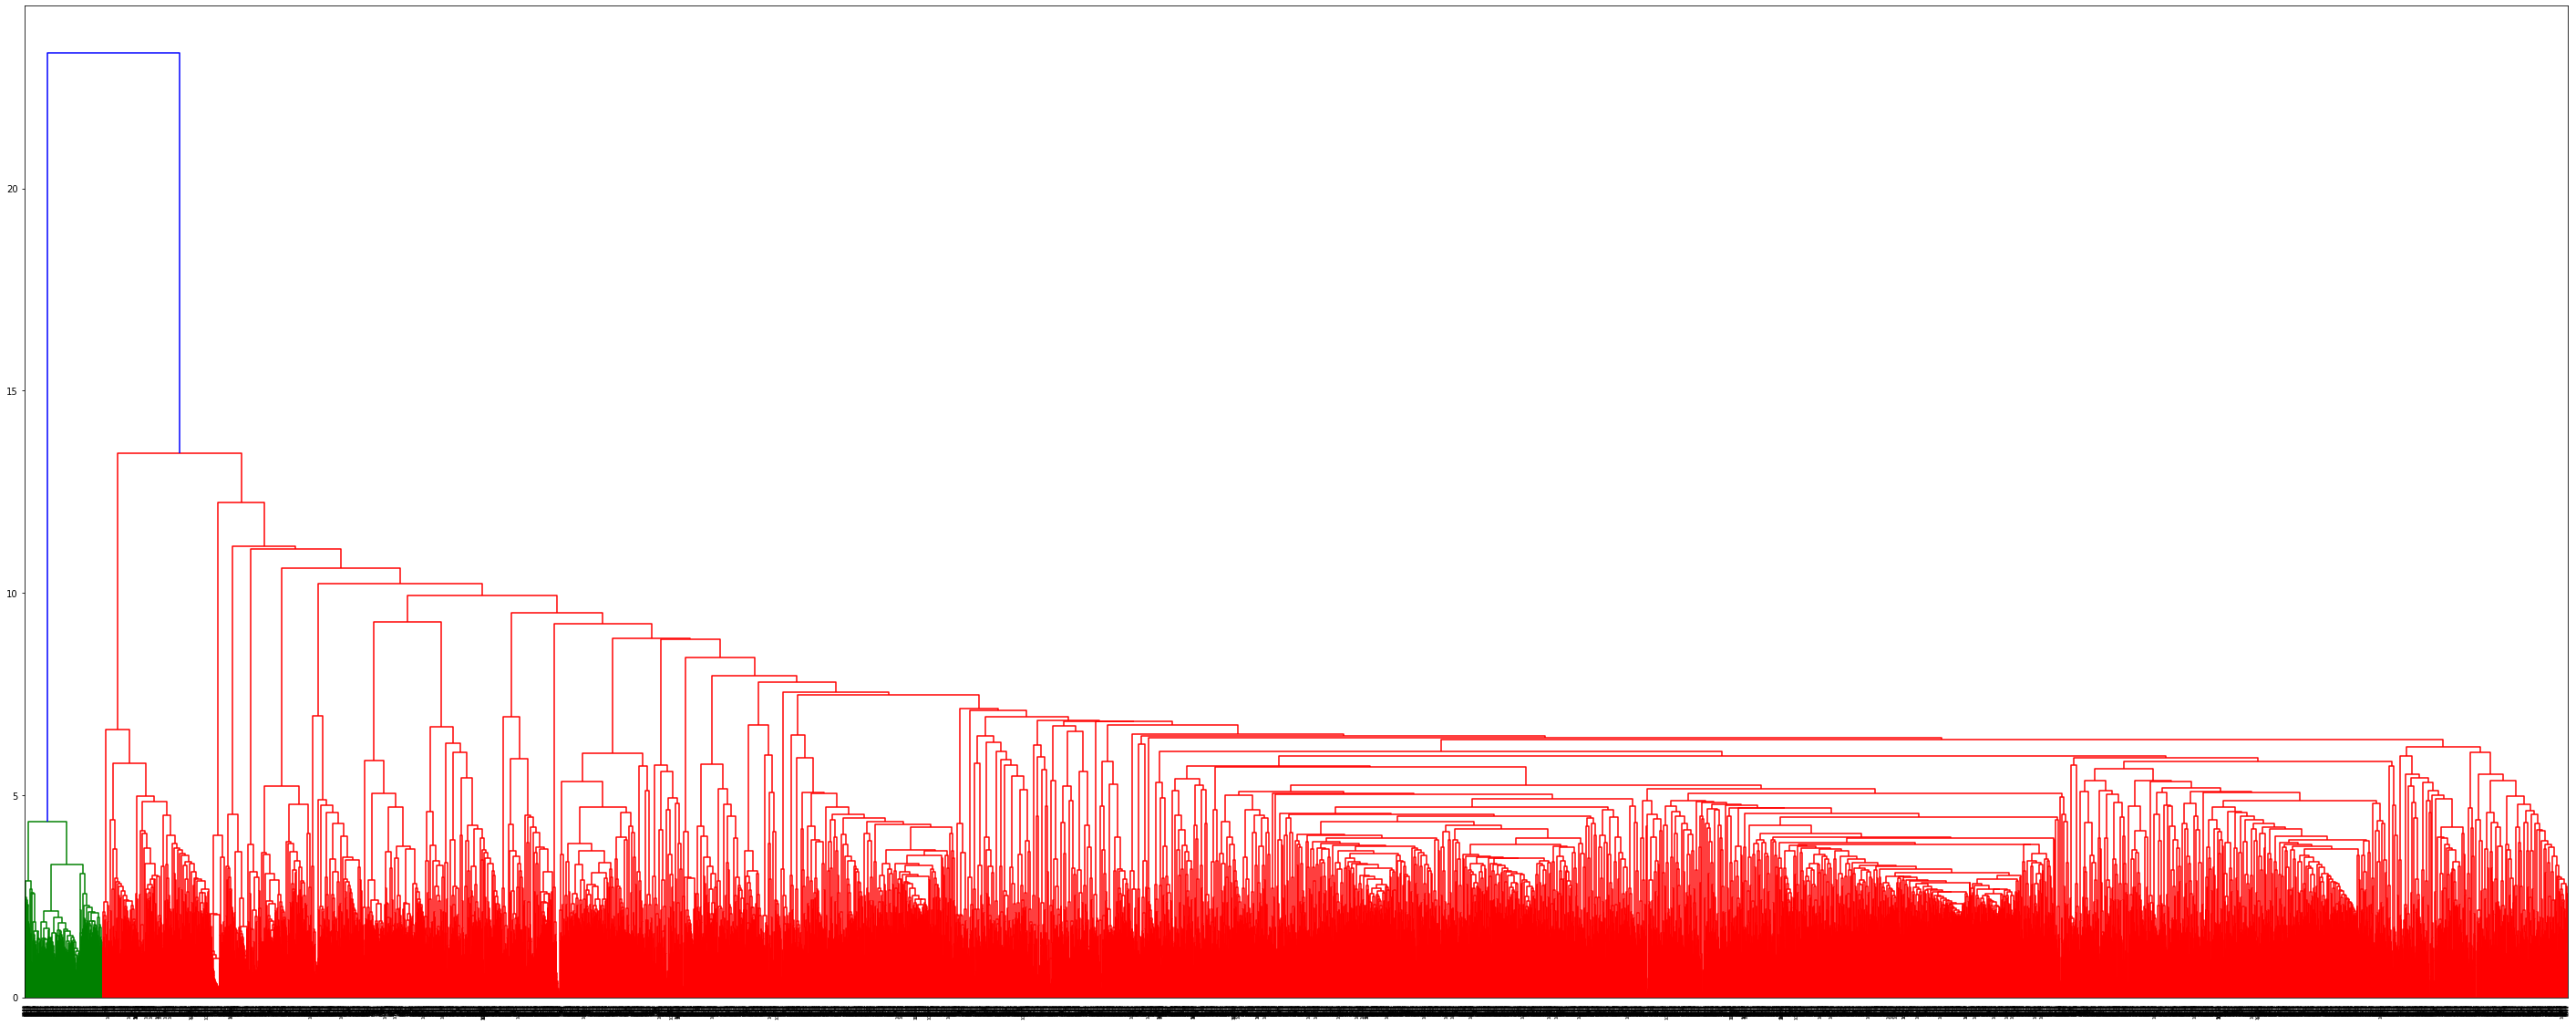

In [52]:
t0 = time()
L_ward = linkage(y=dist_eucl_arr,method='ward')
fig = plt.figure(figsize=(50,20))
dn=dendrogram(L_ward)
print("This took %0.3fs." % (time() - t0))

In [56]:
from scipy.cluster.hierarchy import is_valid_linkage
print(is_valid_linkage(L_ward))

True


In [53]:
cos_dist_arr = ssd.squareform(dist_cos)

In [54]:
t0= time() 
L_avg=linkage(cos_dist_arr,method='average')
print("This took %0.3fs." % (time() - t0))

This took 5.762s.


Alot faster when we leave out the dendogram.

In [57]:
from scipy.cluster.hierarchy import cut_tree

clust_assign_ward = []
clust_assign_avg =[]

#extract clusterings of sizes 2 to 50
for n in range(50):
    clust_assign_ward.append( (cut_tree(L_ward,n+1)).flatten() )
    clust_assign_avg.append( (cut_tree(L_avg,n+1)).flatten() )

## 3-3 Cluster Evaluation
* Use the 'c' attribute from the original data as ground truth
* Use internal measures such as ARI *and* NMI for evaluation (from sklearn, not in scipy...)
* Plot a curve showing the result quality for at least ARI and NMI
* Discuss these findings. What do you observe?
* What are the best parameters found using the labels?
* Print the number of elements in each cluster of the best clustering
* Compute the Silhouette coefficient of the best result (hint: use the distance matrix again). Measure the run time.
* Is the Silhouette score good?

In [58]:
ground_truth = []

#extract the 'c' variable from our raw text corpus as a ground truth
for i in range(len(raw)):
    ground_truth.append(raw[i]['c'])

set(ground_truth)

{'Characters', 'Episodes', 'Gags', 'Locations', 'Objects', 'Songs', 'Trivia'}

In [59]:
from sklearn.metrics import adjusted_rand_score as ARI
from sklearn.metrics import normalized_mutual_info_score as NMI

rand_ind_ward = []
rand_ind_avg = []

#calculate adjusted Rand Index for each extracted clustering
for i in range(50): 
    rand_ind_ward.append( ARI(clust_assign_ward[i],ground_truth) )
    rand_ind_avg.append( ARI(clust_assign_avg[i],ground_truth) )


In [298]:
rand_ind_ward[11]

0.09557600638385055

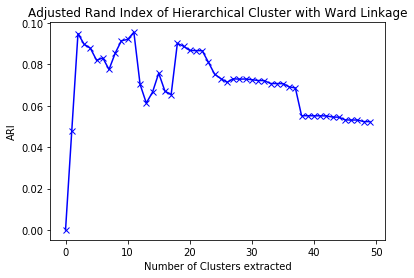

In [98]:
import matplotlib.pyplot as plt
xint= range(0,50)
plt.plot(xint, rand_ind_ward, 'bx-') 
plt.xlabel('Number of Clusters extracted')
plt.xticks()
plt.ylabel('ARI') 
plt.title('Adjusted Rand Index of Hierarchical Cluster with Ward Linkage') 
plt.show() 


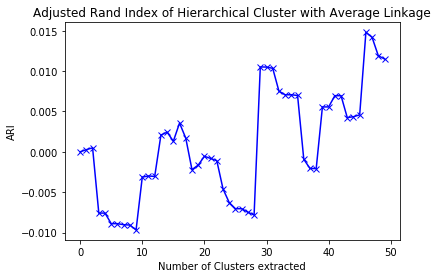

In [99]:
import matplotlib.pyplot as plt
xint= range(0,50)
plt.plot(xint, rand_ind_avg, 'bx-') 
plt.xlabel('Number of Clusters extracted')
plt.xticks()
plt.ylabel('ARI') 
plt.title('Adjusted Rand Index of Hierarchical Cluster with Average Linkage') 
plt.show() 

The ARI values are unaccaptably low, in the case of Average-Linkage even below zero, which means we have a below-random performance.
However, I have the impression, that very high scores on this dataset with this ground truth are not possible, since teh ground truth.. well is not the ground truth. Documents labeled with 'Character' do not differ greatly in the words occuring from those labeled 'Episodes'. This means they do not actually differ in the tf-idf space, in which we are clustering. If we actually wanted to find differences between them, we would have to do a completely different preprocessing to span a different space. Alternatively, we could use algorithms for classification, since we have these labels.

In [62]:
from sklearn.metrics import silhouette_score as silhouette

In [64]:
pred_labels = clust_assign_ward[4]

t1 = time()
sh = silhouette(X=dist_cos, metric= 'precomputed', labels=pred_labels, random_state=42 )
print("done in %0.3fs." % (time() - t1))

done in 0.893s.


In [65]:
print("Silhouette of 11 Clusters with Ward Linkage", sh)

Silhouette of 11 Clusters with Ward Linkage 0.002141208480971077


The silhouette score virtually equals zero, which is unacceptably low.
I have tried to get better results, but with the huge runtime of the hierarchical clustering, it is hard to experiment whith it.

In [69]:
import collections
collections.Counter(clust_assign_ward[11])

Counter({0: 7995,
         1: 249,
         2: 201,
         3: 204,
         4: 306,
         5: 60,
         6: 200,
         7: 57,
         8: 88,
         9: 427,
         10: 311,
         11: 28})

In [72]:
7995 / len(clust_assign_ward[11])

0.7895516492198301

The Clusters are of very different sizes with one containing over 3/4 of the instances.

## 3-4 k-Means clustering
* Run k-means clustering on the TF-IDF vectors (*not* on the distance matrix)
* The newest sklearn is supposedly much faster (and has some bugs fixed)
* Try at least k=2..20.
* It is okay to reduce n_init and max_iter to reduce the run time to <1 hour total (!)
* For repeatability, use a fixed random seed.
* Make an Elbow plot. Discuss it.
* Plot a curve showing the result quality for ARI. Print the best ARI.
* Optional: implement *spherical* k-means yourself (my spherical k-means is several times faster than sklearns!)

class sklearn.cluster.KMeans(n_clusters=8, *, init='k-means++', n_init=10, max_iter=300, tol=0.0001, precompute_distances='deprecated', verbose=0, random_state=None, copy_x=True, n_jobs='deprecated', algorithm='auto')

In [73]:
from sklearn.cluster import KMeans

In [318]:
K = range(1,20) 

inertias = []
pred_labels = {}

#train the model depending in k and save inertias, mapping, and predicted labels
for k in K: 
    kmeanModel = KMeans(n_clusters=k,n_init=6, max_iter=250,tol=0.001, random_state=2006).fit(tfidf)   
      
    inertias.append(kmeanModel.inertia_)
    pred_labels[k] = kmeanModel.labels_

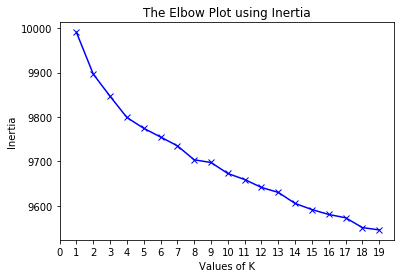

In [319]:
import matplotlib.pyplot as plt
xint= range(0,20)
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K')
plt.xticks(xint)
plt.ylabel('Inertia') 
plt.title('The Elbow Plot using Inertia') 
plt.show() 


Obviously, the SSE to the closest cluster center is stricly decreasing.
Looking for an 'elbow', we find 4, 8 and 14 as potentially good choices for K.
The latter are very plausible, since 7 is the true number of clusters in our data according to the ground truth.

In [181]:
ground_truth = []

for i in range(len(raw)):
    ground_truth.append(raw[i]['c'])

In [182]:
set(ground_truth)

{'Characters', 'Episodes', 'Gags', 'Locations', 'Objects', 'Songs', 'Trivia'}

In [356]:
from sklearn.metrics import adjusted_rand_score as ARI


In [321]:
ARIs = []

for i in range(1,20):
    ari = ARI(pred_labels[i],ground_truth)
    ARIs.append(ari)

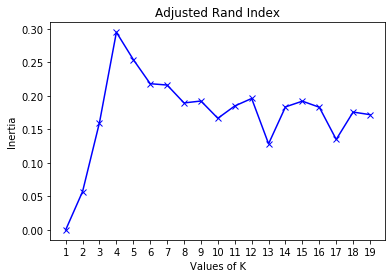

In [322]:

xint= range(1,20)
plt.plot(K, ARIs, 'bx-') 
plt.xlabel('Values of K')
plt.xticks(xint)
plt.ylabel('Inertia') 
plt.title('Adjusted Rand Index') 
plt.show() 

In [323]:
print("Best ARI:", round(ARIs[3],3))

Best ARI: 0.295


This is okay but not very good.

## 3-5 Clusters as topics
For the best k-means clustering found above:

* Print the number of elements in each cluster
* Identify the most important words for each cluster centroid as a "cluster topic".
* Identify the document closest to the cluster center
* Discuss the clustering result

With the best ARI Score at 4 and the first elbow we identified, let's consider the Four-Means Model as out best in order to inspect it more closely in the following.

In [75]:
# retrain the best kMeans Model:
from time import time
t0 = time()
fourMeans = KMeans(n_clusters=4,n_init=6, max_iter=250,tol=0.001, random_state=2006).fit(tfidf) 
print("This took", time() - t0, "seconds")

This took 96.55360198020935 seconds


In [278]:
centroids = fourMeans.cluster_centers_


In [87]:
import collections
collections.Counter(fourMeans.labels_)

Counter({3: 1167, 2: 7745, 0: 845, 1: 369})

In [88]:
all = 1167 + 7745 + 845 + 369
(1167+7745)/all

0.8801106063598657

The clusters are of very different sizes, which makes it rather hard to interpret them nicely.

Calculate Cosine Similiarity between Centroids and all words.

In [288]:
print("Top terms per cluster:")
order_centroids = fourMeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for k in range(4):
    print(end='\n')
    print("Cluster %d:" % k),
    for ind in order_centroids[k, :15]:
        print(' %s' % terms[ind], end='')
        
    print

Top terms per cluster:

Cluster 0:
 song sung played homer lyrics lisa performed bart love marge treehouse horror episode parody theme
Cluster 1:
 couch simpson maggie plot appearances homer family marge season character lisa bart room simpsons sits
Cluster 2:
 springfield homer history bart simpson lisa simpsons burns also marge family seen krusty episode school
Cluster 3:
 homer bart marge lisa episode burns family springfield back however simpsons tells gets home school

In [284]:
from sklearn.metrics import pairwise_distances 
                                   
centroid_doc_dists = pairwise_distances(X=tfidf, Y=centroids, metric='cosine')
#centroid_doc_dists.shape
#type(centroid_doc_dists)

In [327]:

print("Most similar documents to cluster centroids")
for j in range(4):
    doc_inds = centroid_doc_dists[:,j].argsort()
    print("___________________")
    print("Cluster", j)
    
    for i in range(7):
        index=doc_inds[i]
        title = raw[index]['title']
        print(index,title)

Most similar documents to cluster centroids
___________________
Cluster 0
8855 Ragtag Bunch of Mistfits
8854 G.I. Jane Musical
8853 Paul Blart Musical
8856 Corey Leak
8810 Skinner is a Nut
8102 The Odd Couple Theme Song
6922 Homer (song)
___________________
Cluster 1
4090 Homer's Couch couch gag
4282 Family Couch couch gag
5625 Couch Falling from the Sky and Crushing the Family couch gag
4244 Lying Down Bart couch gag
4272 Fat Man couch gag
6522 Modern Couch Gag couch gag
4286 Trampoline Couch couch gag
___________________
Cluster 2
3614 Homer Simpson
3615 Bart Simpson
3616 Marge Simpson
14 Abraham Simpson II
2012 Robert Terwilliger
3617 Lisa Simpson
969 References in other media
___________________
Cluster 3
3614 Homer Simpson
3615 Bart Simpson
3616 Marge Simpson
802 Barting Over
141 Moaning Lisa
3647 Holidays of Future Passed
4185 Treehouse of Horror XXIII


#### Interpretation of Clusters

The first two Clusters, which contain far less documents than the other two, can be interpreted more clearly because they are more distinct.
- The first is clearly characterized through music. Mostly containing documents describing certain songs or musical-like episodes and words like "song, sung, lyrics, performed"
- In the second cluster couch gags were gathered.
- The third cluster alone contains over 3/4 of all documents! It can probably be best described as "ordinary document". Coomon words are the character names and frequently visited places.
- How the fourth cluster differentiates from the former is not entirely clear to me. It seems to be more focused on the kids, Lisa and Bart, and their related words like school etc.


In this case, it would make alot of sense to safe the two clusters we can nicely interpret and rerun kMeans on the other observation to find some more interpretable differences, which we will do later.

## 4-1 Topic Modeling with LSI

Perform Latent Semantic Indexing by performing a truncated SVD of the tfidf or tf matrix.



In [211]:
tfidf.shape

(10126, 44823)

In [212]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=1000, n_iter=7, random_state=42)

svd.fit(tfidf)


TruncatedSVD(algorithm='randomized', n_components=1000, n_iter=7,
             random_state=42, tol=0.0)

In [213]:
print(svd.explained_variance_ratio_.sum())

0.4946771461921531


Around 50% of the obsorved Variance can be explained through the truncated SVD, which seems decent to me with only 1000 components.

In [215]:
svd2 = TruncatedSVD(n_components=2000, n_iter=7, random_state=42)

svd2.fit(tfidf)

print(svd2.explained_variance_ratio_.sum())


0.6677391847918852


We can get better results with a significantly bigger runtime.

## 4-2 Topic Modeling with pLSI and NMF

Perform topic modeling with pLSI by the means of NMF. Experiment with different losses - Kullback-Leibler as in pLSI, but also Frobenius loss.



In [91]:
n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20

In [82]:
def top_words(model, features, n_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([features[i]
                             for i in topic.argsort()[:-n_words - 1:-1]])
        print(message)
    print()


### NMF with Frobenius Norm

In [92]:
t0=time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

done in 3.499s.


In [93]:
tfidf_feature_names = vectorizer.get_feature_names()

print("NMF Model with Frobenius Norm:")
top_words(nmf, tfidf_feature_names, n_top_words)

NMF Model with Frobenius Norm:
Topic #0: springfield school elementary history store shop seen skinner student located mall town teacher students shelbyville principal class name also grade
Topic #1: couch simpson maggie plot appearances family season character marge lisa homer bart room sits living simpsons usual runs second first
Topic #2: song sung played lyrics performed lisa love homer treehouse horror theme parody music written flanders little clausen chorus band happy
Topic #3: homer marge family house flanders back home simpson episode tells however lenny says time springfield gets plant goes later carl
Topic #4: burns charles montgomery smithers plant nuclear power waylon great employee daphne larry mansion monty family heir workers clifford robot robots
Topic #5: simpsons episode american actor show also guest character born appeared season itchy scratchy known voice film series voiced starred writer
Topic #6: spuckler cletus brandine children mary many incest wheel baby race

My Interpretation
- Topic #0: School
- Topic #1: Couch Gags
- Topic #2: Songs & Music
- Topic #3: Characters
- Topic #4: Smithers & Nuclear Plant 
- Topic #5: Guest Stars
- Topic #6: Political (?)
- Topic #7: Stories sorrounding Lisa
- Topic #8: Krusty Clown
- Topic #9: Simpsons Family

### NMF with Kulback Leibler Divergence

In [94]:
nmf_kl = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)


In [95]:
print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")

top_words(nmf_kl, tfidf_feature_names, n_top_words)


Topics in NMF model (generalized Kullback-Leibler divergence):
Topic #0: bart history lisa homer marge springfield like later also first seen school simpsons however time simpson episode told said behind
Topic #1: simpson couch character maggie family appearances plot season room sits living runs usual sitting second sixth dressed except onto ninth
Topic #2: song sung homer lyrics played lisa performed music love treehouse written horror parody album clausen track theme sing little flanders
Topic #3: homer marge power plant nuclear home tells asks carl lenny works employee takes work tries back night gets however says
Topic #4: history burns behind laughter springfield seen montgomery also name parody charles simpson simpsons appearance country nuclear along many united member
Topic #5: simpsons episode american show actor also appeared born known character guest series voiced season movie film television voice best starred
Topic #6: children family brandine many cletus spuckler house

## 4-3 Topic Modeling with LDA

Perform topic modeling with LDA. Consider trying different implementations (e.g., sklearn, gensim).



In [79]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# NMF need a tf, which we will build now
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=3,
                                max_features=n_features,
                                stop_words='english')

tf = tf_vectorizer.fit_transform(all_text)



In [85]:
lda = LatentDirichletAllocation(n_components=10, max_iter=5,
                                learning_offset=50.,
                                random_state=42)
t0 = time()
lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [86]:
print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model:
Topic #0: springfield ned homer flanders history lisa house selma marge simpson book patty bart ralph told wiggum man lovejoy simpsons children
Topic #1: springfield simpsons american film scratchy itchy episode actor movie voice known born school character tony history series guest krusty city
Topic #2: bart homer lisa school skinner milhouse nelson marge says springfield little episode principal like krusty martin willie gets tells time
Topic #3: simpson couch gag family homer maggie bart marge lisa great season abe character bouvier plot appearances simpsons abraham room mona
Topic #4: homer moe barney simpsons lenny marge car carl simpson springfield game beer family time later tavern maggie duff bar like
Topic #5: burns mr springfield homer smithers plant apu nuclear power history mart store charles kwik montgomery shop simpson new bart country
Topic #6: homer marge lisa bart episode family tells season home story house gets goes simpsons maggie new says spri

## 4-4 Detailed Evaluation

Study the results above. Also compare the results to spherical k-means before.

Argue which method worked best and *why*. Since many methods will be sensitive to preprocessing and random initialization, re-run the "best" method with different parameters, and compare the results.

Consider evaluation based on the existing labels. What are your findings.

Document your results, the evaluation will be the key part of the Studienleistung: Assuming you had been assigned to perform topic modeling on this data set by your boss as part of your job, how would you present the results to your group (that does not know all these algorithms)? What methods would you recommend to purse further, what preprocessing, and *why*?

What I subjectively find the easiest to interpret is the NMF Model. This is due to the fact, that it only infers additive relationships. 
I guess this approach would also be easier to explain to non-technical colleagues. Even if it's not actually true, eigenvalues and -vectors sound very abstract and confusing to alot of people.
Nonnegative Matrix Factorization however, can be explained quite easily:
We have our term frequencies saved in a nxm matrix M. We factorize it into two different matrices, W (nxr) and H (rxm), with no negative entries. r concerns the dimension of the inner product and thus the accuracy of approximation. 
How exactly this is done algoritithmically should not bother the client, but we can tell them that it is proven to converge to a local optimum.

If the factorization is done, we can interpret these matrices nicely:
* W contains our basis topics
* H contains column-wise encodings, which create the observations in M through linear combinations of the basis topics.

So each document is (modeled to be) created by adding up these topics.
If we are interested ehich "basic themes" the writers of the Simpsons have utilized, we can find them this way.

Let's rerun the NMF with Frobenius Norm with less components and another seed.

In [310]:
n_components = 5


t0=time()
nmf2_frob = NMF(n_components=n_components, random_state=2020,
          alpha=.1, l1_ratio=.5,
          max_iter= 300, tol=0.00001).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

done in 2.481s.


In [311]:
print("Second NMF Model with Frobenius Norm:")
print_top_words(nmf2_frob, tfidf_feature_names, 12)

Second NMF Model with Frobenius Norm:
Topic #0: bart lisa springfield school episode krusty simpsons also history milhouse book show
Topic #1: couch simpson maggie plot appearances family season character marge lisa bart homer
Topic #2: song sung played lyrics lisa performed love treehouse horror theme homer parody
Topic #3: homer marge family back tells lenny home plant simpson says flanders carl
Topic #4: burns charles montgomery smithers plant nuclear power great springfield employee waylon daphne



In [239]:
print("Second NMF Model with Frobenius Norm:")
print_top_words(nmf2_frob, tfidf_feature_names, 12)

Second NMF Model with Frobenius Norm:
Topic #0: bart lisa springfield school episode krusty simpsons also history milhouse book show
Topic #1: couch simpson maggie plot appearances family season character marge lisa bart homer
Topic #2: song sung played lyrics lisa performed love treehouse horror theme homer parody
Topic #3: homer marge family back tells lenny home plant simpson says flanders carl
Topic #4: burns charles montgomery smithers plant nuclear power great springfield employee waylon daphne



This is a more compressed representation of the basic topics we find in this text corpus.
There is one topic sorrounding the kids and their life in school and other places.
Another prominent, seemingly quite distinct topic, in our text is the concept of couch gags.
Besides, we have musical-episodes and other music topics.
Another origin of content is the family life at Simpson's between Homer's job at the power plant and his neighboorhood disputes with Flanders.
Lastly, the episodes are filled with Homer's work at Mr. Smithers power plant.


Evaluating NMF with the ground truth used earlier for cluster assignment, does not make alot of sense here. NMF does not make a "hard assignment" but any document basically consists of a mixture of all topics. 
Also, I have the impression, that the classification done in the ground truth follows a different goal than the topic modeling done here.

Instead, let's further inspect our kMeans result and try to enhance it.

In [329]:
#recall the uneven cluster sizes:
collections.Counter(fourMeans.labels_)

Counter({3: 1167, 2: 7745, 0: 845, 1: 369})

In [330]:
labels_4M = fourMeans.labels_
labels_4M.shape

(10126,)

We want to keep cluster assignements 2 and 3, but further cluster such with 0 or 1.
So we first define a filter:

In [347]:
filter = np.array( [e == 2 or e == 3 for e in labels_4M] )


In [349]:
#for indexing a sparse matrix we have to do this extra step:
indeces = filter.nonzero()[0]

tf_remain = tfidf[indeces,:]
tf_remain.shape

(8912, 44823)

In [350]:
K = range(1,15) 

inertia = []
pred_label = {}

#train the model depending in k and save inertias, and predicted labels
for k in K: 
    kmeanModel = KMeans(n_clusters=k,n_init=3, max_iter=150,tol=0.001, random_state=2706).fit(tf_remain)   
      
    inertia.append(kmeanModel.inertia_)

    pred_label[k] = kmeanModel.labels_

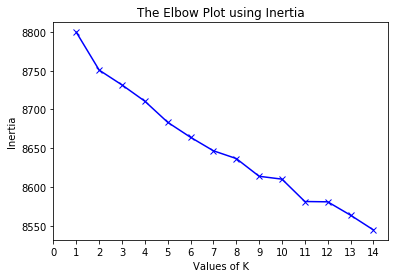

In [352]:

import matplotlib.pyplot as plt
xint= range(0,15)
plt.plot(K, inertia, 'bx-') 
plt.xlabel('Values of K')
plt.xticks(xint)
plt.ylabel('Inertia') 
plt.title('The Elbow Plot using Inertia') 
plt.show() 


We identify the clearest elbow at 11 and retrain our 11Means Model.

In [359]:
elevenMean = KMeans(n_clusters=11,n_init=3, max_iter=150,tol=0.001, random_state=2706).fit(tf_remain)

In [369]:
print("Top terms per cluster:")
ordered_centroid = elevenMean.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for k in range(11):
    print(end='\n')
    print("Cluster:", k+3),
    for ind in ordered_centroid[k, :10]:
        print(' %s' % terms[ind], end='')
        
    print

Top terms per cluster:

Cluster: 3
 spuckler itchy scratchy cletus brandine children land park theme show
Cluster: 4
 homer bart marge lisa episode family back springfield tells simpsons
Cluster: 5
 store springfield shop mall located sells street parody towne laughter
Cluster: 6
 bouvier great gurney marcel siblings marceau marge simpson angelique maternal
Cluster: 7
 krusty clown show bart burger sideshow history episode homer springfield
Cluster: 8
 american actor simpsons guest episode born season starred known voiced
Cluster: 9
 burns charles montgomery smithers plant nuclear homer power springfield simpson
Cluster: 10
 school elementary springfield bart lisa skinner student class teacher students
Cluster: 11
 homer springfield simpson history bart lisa marge family also simpsons
Cluster: 12
 book comic books history lisa angelica homer read bart button
Cluster: 13
 wiggum police vehicle truck chief officer level ralph springfield simpsons

I like the results alot better now. 
Ontop of the two clearly identified clusters from before concerning Couch Gags and Musicals, we were now able to divide what we called "usual Simpsons Content" earlier into more distinct cluster, which we can interpret nicely:

Cluster number..
- #3: Around Cletus Spuckler, his wife and Itchy and Scratchy, which can all be considered as side kicks.
- #4: This seems to be the cluster around the Simpsons Family.
- #5: Shopping in Springfield's mall.
- #6: Seem to be characters higher up Simpsons's family tree.
- #7: Crusty Clown Show, and Krusty's Burger.
- #8: real-life star guests.
- #9: Mr Burns and the nuclear plant.
- #10: Springfield's Elementary School.
- #11: Another Family Cluster
- #12: Lisa's stories around books and angelica
- #13: Wiggum, the police officer with his son Ralph

In contrast to NMF before, which was more explorative concerning latent topics "behind" our text corpus, this is a more direct way to differentiate between actual documents (by measuring their cosine-distance in high-dimensional tf-idf space).

This approach would be of good fit, if our boss gave us the task to build a recommendation algorithm for the simpsons wiki. If a reader is on the page of the simpsons wiki, and we want to recommend another article to him, it might make sense to consider articles, which are of the same cluster. For the final decision, which one we actually choose, other information, like user's clicking history would certainly be of help.

Prototypical documents can be seen below:

In [366]:
centroids_11 = elevenMean.cluster_centers_
centroid_doc_dist = pairwise_distances(X=tf_remain, Y=centroids_11, metric='cosine')
print("Most similar documents to cluster centroids")
for j in range(11):
    doc_inds = centroid_doc_dist[:,j].argsort()
    print("___________________")
    print("Cluster", j+3)
    
    for i in range(7):
        index=doc_inds[i]
        title = raw[index]['title']
        print(index,title)

Most similar documents to cluster centroids
___________________
Cluster 3
1283 Springfield Plasma Center
1285 Brian K. Roberts
1294 Wesley Spuckler
1286 David Sacks
1284 Mike Judge
1289 Nigel (manager)
1280 Capital City Stadium
___________________
Cluster 4
3520 Number 2
3522 Ira Glass (character)
3521 Sprooklyn Bridge
794 Moe Baby Blues
4072 Chile
141 Moaning Lisa
375 Lisa's Pony
___________________
Cluster 5
1247 Springfield Googolplex Theatres
71 Springfield
7593 Polo Field House
1906 Brian Grazer
5719 Keith
1165 Mrs. Muntz
4378 Tarzan couch gag
___________________
Cluster 6
5186 Shelbyville Milhouse's dog
1774 In the Name of the Grandfather
2743 Joe Frazier
1804 Waylon Smithers, Sr.
7493 El Sol
2744 The Ramones
2709 Little Bearded Woman
___________________
Cluster 7
25 Krusty the Clown
28 Krusty Gets Busted
310 The Shell Game
337 Celeste
823 Simple Simpson
5457 Theodore L'eau
6706 Iron Man (song)
___________________
Cluster 8
3385 Sideshow Blob
5303 Springfield National Park
7120 P